# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Student note to reviewer: 
Hello!  I am not able to run the code below in the Udacity Workspace. 
However it works just fine in Colab with GPU. Here's my notebook, re-run without GPU.

## Import Resources

In [40]:
# TODO: Make all necessary imports.

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()

import warnings
warnings.filterwarnings('ignore')

#Set high resolution display for plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()

import json
from PIL import Image


In [41]:
# To keep keras results reproducible
tf.random.set_seed(1234)

In [42]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print('Hub version:', hub.__version__)
print('Running on GPU' if tf.config.list_physical_devices('GPU') else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.5.0
tf.keras version: 2.5.0
Hub version: 0.12.0
GPU device not found. Running on CPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [43]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
training_set, testing_set, validation_set = dataset['train'], dataset['test'], dataset['validation']

In [44]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [45]:
# Check dataset is a dictionary
type(dataset)

dict

In [46]:
# Print keys of dataset
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [47]:
print(len(dataset['test']))
print(len(dataset['train']))

6149
1020


## Explore the Dataset

In [48]:
# TODO: Get the number of examples in each set from the dataset info.

num_training_examples = dataset_info.splits['train'].num_examples
num_testing_examples = dataset_info.splits['test'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
total = num_training_examples + num_testing_examples + num_validation_examples
print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the testing set'.format(num_testing_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('Total = {:,} images'.format(total))

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('\nThere are {:,} classes in our dataset'.format(num_classes))

There are 1,020 images in the training set
There are 6,149 images in the testing set
There are 1,020 images in the validation set
Total = 8,189 images

There are 102 classes in our dataset


In [49]:
# TODO: Print the shape and corresponding label of 3 images in the training set.

print('Shapes and Labels of 3 images in training set:\n')

for image, label in training_set.take(3):
    print('shape:', image.shape) 
    print('image type: ', image.dtype)
    print('label type:', label.dtype)
    print('label:', label.numpy())
    print('\n')

Shapes and Labels of 3 images in training set:

shape: (500, 667, 3)
image type:  <dtype: 'uint8'>
label type: <dtype: 'int64'>
label: 72


shape: (500, 666, 3)
image type:  <dtype: 'uint8'>
label type: <dtype: 'int64'>
label: 84


shape: (670, 500, 3)
image type:  <dtype: 'uint8'>
label type: <dtype: 'int64'>
label: 70




The images have different shapes. Image dtype is uint8 (0-255 pixels) whereas label dtype is int64 (integers value)

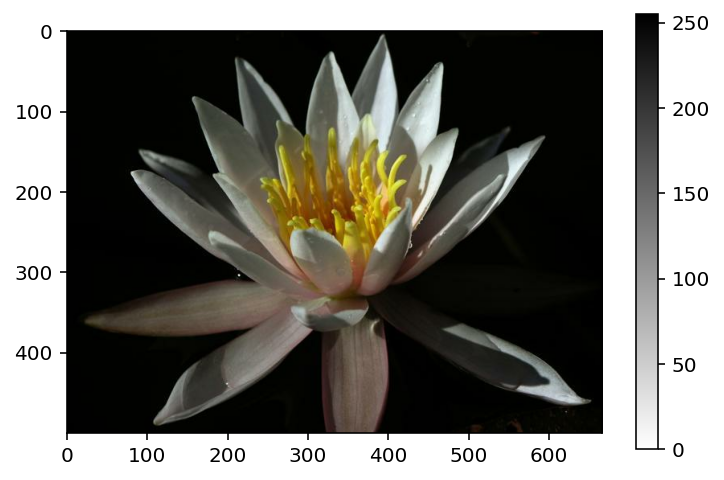

 Label of this image is: 73


In [50]:
# TODO: Plot 1 image from the training set. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy() + 1  # Need to add 1 to the indice to get the label
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()

#Display plot 
plt.show()

# Set the title of the plot to the corresponding image label
print(' Label of this image is: {}'.format(label))

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [51]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [52]:
class_names.keys()

dict_keys(['21', '3', '45', '1', '34', '27', '7', '16', '25', '26', '79', '39', '24', '67', '35', '32', '10', '6', '93', '33', '9', '102', '14', '19', '100', '13', '49', '15', '61', '31', '64', '68', '63', '69', '62', '20', '38', '4', '86', '101', '42', '22', '2', '54', '66', '70', '85', '99', '87', '5', '92', '28', '97', '57', '40', '47', '59', '48', '55', '36', '91', '29', '71', '90', '18', '98', '8', '30', '17', '52', '84', '12', '11', '96', '23', '50', '44', '53', '72', '65', '80', '76', '37', '56', '60', '82', '58', '75', '41', '95', '43', '83', '78', '88', '94', '81', '74', '89', '73', '46', '77', '51'])

In [53]:
# retrieve the value associated with sample class_name key
class_names['73']

'water lily'

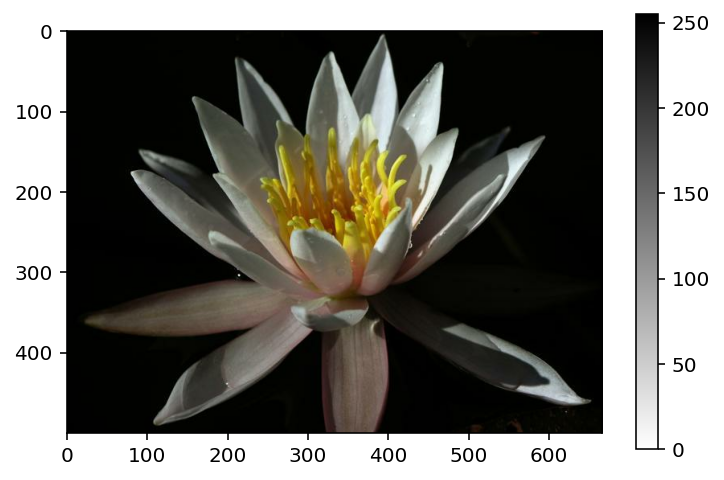

Label of this image: 73
Class name of this image: water lily


In [54]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy() + 1
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()

#Display plot
plt.show()

# Set title of plot
print('Label of this image: {}'.format(label))
print('Class name of this image: {}'.format(class_names[str(label)]))


## Create Pipeline

In [55]:
# TODO: Create a pipeline for each set.

# A function to normalize images:
# 1. Re-cast image from utf8 to float32 datatype
# 2. Since images are now of different sizes (as seen in our sample of 3 images ), reshape them to 224x 224
# 3. Rescale pixel values (range 0-255) to range (0,1)

IMAGE_RES = 224

def normalize(image, label):
  image = tf.cast(image, tf.float32) 
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).map(normalize).batch(BATCH_SIZE).prefetch(1)
testing_batches = testing_set.cache().map(normalize).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.cache().map(normalize).batch(BATCH_SIZE).prefetch(1)


In [56]:
# Confirm that each batch has 64 images of 224 x 224 with 3 channels.
for image, label in training_batches.take(1):
  print('training batch 1:')
  print(image.shape)
  print(image.dtype)
  print(label.numpy() +1 ) 

for image, label in testing_batches.take(1):
  print('\ntesting batch 1:')
  print(image.shape)
  print(image.dtype)
  print(label.numpy() + 1)

for image, label in validation_batches.take(1):
  print('\ntraining batch 1:')
  print(image.shape)
  print(image.dtype)
  print(label.numpy() + 1)

training batch 1:
(64, 224, 224, 3)
<dtype: 'float32'>
[  3  46  16  85  40   3  76  66   5  31  24   3  40  74  15  43   4  58
  58  42  17  89  87  29  96  26  51  53  10  49  93  13  80  23  88  52
 100  45   4  80  21  61  55  12   2  91  56 102   1   9  14  30  84  22
  36  87  27  40  70  96  16  43  70   4]

testing batch 1:
(64, 224, 224, 3)
<dtype: 'float32'>
[ 41  77  43  64  95  46  95  20  52  47  74  71  73  94  90  11  96  73
  50  76  58  76  78  46  46  25  96  66  90  73  74  89  50  80  78  85
  96  98  81  86  70  77  95  53  36  52  77  41  78  52  60  76  13   7
  81  46  56  88  94  80 102  94   6  92]

training batch 1:
(64, 224, 224, 3)
<dtype: 'float32'>
[89 55  9 38 14 53 30 68 95  8 76 59 89 90 88 87 13 84 19  6 85 86 85 82
 78 35 58 45 80 81 59 79 74  1 42 99  6 84 88 43 41 54 12 55 70 45 62 27
 77 43 99 13 95 90 38 61 74 18  8 31 28 21  7 98]


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [57]:
# TODO: Build and train your network using transfer learning
# Use MobileNet pre-trained classifier model URL from TF Hub
url= 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4'

# Set up Keras layer with the pre-trained Hub model. Input shape is the shape of our RGB image (224 x 224 x 3 channels)
feature_extractor = hub.KerasLayer(url, input_shape=(224, 224, 3))

# Freeze weights and biases in the pre-trained Hub model to prevent model from re-training
feature_extractor.trainable = False


In [58]:
# Build and train the model with the feature_extractor and an output layer with 102 classes (102 flower labels) and softmax activation (output predicted probabilities associated with each label)

model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(102, activation ='softmax')
        ])

#Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 102)               102204    
Total params: 3,642,469
Trainable params: 102,204
Non-trainable params: 3,540,265
_________________________________________________________________


In [59]:
# Compile model 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',    # predicting multi-classes with integers as labels
              metrics=['accuracy'])                      

In [60]:
# Evaluate loss and accuracy on one training batch before training. Accuracy is expected to be very low before training
for image, label in training_batches.take(1):
    loss, accuracy = model.evaluate(image, label)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - ETA: 1s - loss: 5.7523 - accuracy: 0.0000e+ - ETA: 0s - loss: 5.8853 - accuracy: 0.0000e+ - 2s 481ms/step - loss: 5.8853 - accuracy: 0.0000e+00

Loss before training: 5.885
Accuracy before training: 0.000%


 Accuracy before training is 0%, very low indeed!

In [61]:
# Train model for up to indicated number of epochs callback options 
# This early stopping callback will stop the training when there is no improvement in
# the quantity to monitor (val loss)  for three consecutive epochs or when the min_delta is 0.001

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=3)

EPOCHS = 100   # number of times the training is passed through the model

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches,
                    callbacks = [early_stopping])

Epoch 1/100
16/16 [==============================] - ETA: 1:15 - loss: 5.9743 - accuracy: 0.0000e+ - ETA: 14s - loss: 5.6746 - accuracy: 0.0000e+00 - ETA: 13s - loss: 5.6073 - accuracy: 0.0052    - ETA: 12s - loss: 5.5784 - accuracy: 0.007 - ETA: 11s - loss: 5.5869 - accuracy: 0.009 - ETA: 10s - loss: 5.5731 - accuracy: 0.010 - ETA: 9s - loss: 5.4618 - accuracy: 0.020 - ETA: 8s - loss: 5.3599 - accuracy: 0.02 - ETA: 7s - loss: 5.2988 - accuracy: 0.02 - ETA: 6s - loss: 5.2140 - accuracy: 0.02 - ETA: 5s - loss: 5.1461 - accuracy: 0.03 - ETA: 4s - loss: 5.0687 - accuracy: 0.04 - ETA: 3s - loss: 4.9806 - accuracy: 0.05 - ETA: 2s - loss: 4.8977 - accuracy: 0.06 - ETA: 1s - loss: 4.8358 - accuracy: 0.06 - ETA: 0s - loss: 4.7672 - accuracy: 0.06 - 40s 2s/step - loss: 4.7672 - accuracy: 0.0686 - val_loss: 3.2839 - val_accuracy: 0.2510
Epoch 2/100
16/16 [==============================] - ETA: 19s - loss: 2.5515 - accuracy: 0.500 - ETA: 15s - loss: 2.5977 - accuracy: 0.421 - ETA: 14s - loss: 2.5

16/16 [==============================] - ETA: 18s - loss: 0.1083 - accuracy: 1.000 - ETA: 16s - loss: 0.0972 - accuracy: 1.000 - ETA: 14s - loss: 0.1002 - accuracy: 1.000 - ETA: 13s - loss: 0.0981 - accuracy: 1.000 - ETA: 12s - loss: 0.0932 - accuracy: 1.000 - ETA: 11s - loss: 0.0941 - accuracy: 1.000 - ETA: 10s - loss: 0.0903 - accuracy: 1.000 - ETA: 8s - loss: 0.0909 - accuracy: 1.000 - ETA: 7s - loss: 0.0897 - accuracy: 1.00 - ETA: 6s - loss: 0.0917 - accuracy: 1.00 - ETA: 5s - loss: 0.0926 - accuracy: 0.99 - ETA: 4s - loss: 0.0917 - accuracy: 0.99 - ETA: 3s - loss: 0.0906 - accuracy: 0.99 - ETA: 2s - loss: 0.0902 - accuracy: 0.99 - ETA: 1s - loss: 0.0908 - accuracy: 0.99 - ETA: 0s - loss: 0.0899 - accuracy: 0.99 - 35s 2s/step - loss: 0.0899 - accuracy: 0.9990 - val_loss: 0.8970 - val_accuracy: 0.7735
Epoch 11/100
16/16 [==============================] - ETA: 18s - loss: 0.0740 - accuracy: 1.000 - ETA: 15s - loss: 0.0792 - accuracy: 1.000 - ETA: 14s - loss: 0.0809 - accuracy: 1.000 

Epoch 20/100
16/16 [==============================] - ETA: 21s - loss: 0.0228 - accuracy: 1.000 - ETA: 17s - loss: 0.0257 - accuracy: 1.000 - ETA: 15s - loss: 0.0269 - accuracy: 1.000 - ETA: 14s - loss: 0.0273 - accuracy: 1.000 - ETA: 13s - loss: 0.0270 - accuracy: 1.000 - ETA: 11s - loss: 0.0274 - accuracy: 1.000 - ETA: 10s - loss: 0.0283 - accuracy: 1.000 - ETA: 9s - loss: 0.0282 - accuracy: 1.000 - ETA: 8s - loss: 0.0280 - accuracy: 1.00 - ETA: 7s - loss: 0.0278 - accuracy: 1.00 - ETA: 6s - loss: 0.0278 - accuracy: 1.00 - ETA: 4s - loss: 0.0282 - accuracy: 1.00 - ETA: 3s - loss: 0.0283 - accuracy: 1.00 - ETA: 2s - loss: 0.0284 - accuracy: 1.00 - ETA: 1s - loss: 0.0285 - accuracy: 1.00 - ETA: 0s - loss: 0.0285 - accuracy: 1.00 - 42s 3s/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.8086 - val_accuracy: 0.7941
Epoch 21/100
16/16 [==============================] - ETA: 27s - loss: 0.0269 - accuracy: 1.000 - ETA: 24s - loss: 0.0263 - accuracy: 1.000 - ETA: 23s - loss: 0.0256 - acc

16/16 [==============================] - ETA: 19s - loss: 0.0152 - accuracy: 1.000 - ETA: 15s - loss: 0.0152 - accuracy: 1.000 - ETA: 14s - loss: 0.0155 - accuracy: 1.000 - ETA: 13s - loss: 0.0153 - accuracy: 1.000 - ETA: 12s - loss: 0.0156 - accuracy: 1.000 - ETA: 11s - loss: 0.0158 - accuracy: 1.000 - ETA: 10s - loss: 0.0163 - accuracy: 1.000 - ETA: 8s - loss: 0.0162 - accuracy: 1.000 - ETA: 7s - loss: 0.0159 - accuracy: 1.00 - ETA: 6s - loss: 0.0158 - accuracy: 1.00 - ETA: 5s - loss: 0.0157 - accuracy: 1.00 - ETA: 4s - loss: 0.0155 - accuracy: 1.00 - ETA: 3s - loss: 0.0158 - accuracy: 1.00 - ETA: 2s - loss: 0.0159 - accuracy: 1.00 - ETA: 1s - loss: 0.0159 - accuracy: 1.00 - ETA: 0s - loss: 0.0160 - accuracy: 1.00 - 39s 3s/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.7774 - val_accuracy: 0.8020
Epoch 30/100
16/16 [==============================] - ETA: 23s - loss: 0.0138 - accuracy: 1.000 - ETA: 18s - loss: 0.0147 - accuracy: 1.000 - ETA: 16s - loss: 0.0143 - accuracy: 1.000 

16/16 [==============================] - ETA: 19s - loss: 0.0118 - accuracy: 1.000 - ETA: 15s - loss: 0.0106 - accuracy: 1.000 - ETA: 14s - loss: 0.0105 - accuracy: 1.000 - ETA: 15s - loss: 0.0107 - accuracy: 1.000 - ETA: 14s - loss: 0.0105 - accuracy: 1.000 - ETA: 13s - loss: 0.0103 - accuracy: 1.000 - ETA: 12s - loss: 0.0105 - accuracy: 1.000 - ETA: 10s - loss: 0.0103 - accuracy: 1.000 - ETA: 9s - loss: 0.0102 - accuracy: 1.000 - ETA: 8s - loss: 0.0104 - accuracy: 1.00 - ETA: 6s - loss: 0.0105 - accuracy: 1.00 - ETA: 5s - loss: 0.0107 - accuracy: 1.00 - ETA: 4s - loss: 0.0105 - accuracy: 1.00 - ETA: 2s - loss: 0.0105 - accuracy: 1.00 - ETA: 1s - loss: 0.0104 - accuracy: 1.00 - ETA: 0s - loss: 0.0105 - accuracy: 1.00 - 41s 3s/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.7612 - val_accuracy: 0.8059
Epoch 39/100
16/16 [==============================] - ETA: 19s - loss: 0.0101 - accuracy: 1.000 - ETA: 16s - loss: 0.0099 - accuracy: 1.000 - ETA: 14s - loss: 0.0102 - accuracy: 1.00

16/16 [==============================] - ETA: 19s - loss: 0.0077 - accuracy: 1.000 - ETA: 15s - loss: 0.0081 - accuracy: 1.000 - ETA: 14s - loss: 0.0081 - accuracy: 1.000 - ETA: 13s - loss: 0.0080 - accuracy: 1.000 - ETA: 12s - loss: 0.0077 - accuracy: 1.000 - ETA: 11s - loss: 0.0076 - accuracy: 1.000 - ETA: 10s - loss: 0.0076 - accuracy: 1.000 - ETA: 9s - loss: 0.0076 - accuracy: 1.000 - ETA: 7s - loss: 0.0077 - accuracy: 1.00 - ETA: 6s - loss: 0.0077 - accuracy: 1.00 - ETA: 5s - loss: 0.0076 - accuracy: 1.00 - ETA: 4s - loss: 0.0075 - accuracy: 1.00 - ETA: 3s - loss: 0.0074 - accuracy: 1.00 - ETA: 2s - loss: 0.0074 - accuracy: 1.00 - ETA: 1s - loss: 0.0074 - accuracy: 1.00 - ETA: 0s - loss: 0.0075 - accuracy: 1.00 - 36s 2s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.7515 - val_accuracy: 0.8078
Epoch 48/100
16/16 [==============================] - ETA: 18s - loss: 0.0073 - accuracy: 1.000 - ETA: 15s - loss: 0.0076 - accuracy: 1.000 - ETA: 14s - loss: 0.0074 - accuracy: 1.000 

16/16 [==============================] - ETA: 20s - loss: 0.0049 - accuracy: 1.000 - ETA: 16s - loss: 0.0057 - accuracy: 1.000 - ETA: 15s - loss: 0.0058 - accuracy: 1.000 - ETA: 14s - loss: 0.0055 - accuracy: 1.000 - ETA: 13s - loss: 0.0055 - accuracy: 1.000 - ETA: 11s - loss: 0.0055 - accuracy: 1.000 - ETA: 10s - loss: 0.0055 - accuracy: 1.000 - ETA: 9s - loss: 0.0057 - accuracy: 1.000 - ETA: 8s - loss: 0.0057 - accuracy: 1.00 - ETA: 6s - loss: 0.0056 - accuracy: 1.00 - ETA: 5s - loss: 0.0057 - accuracy: 1.00 - ETA: 4s - loss: 0.0056 - accuracy: 1.00 - ETA: 3s - loss: 0.0056 - accuracy: 1.00 - ETA: 2s - loss: 0.0057 - accuracy: 1.00 - ETA: 1s - loss: 0.0057 - accuracy: 1.00 - ETA: 0s - loss: 0.0057 - accuracy: 1.00 - 36s 2s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.7442 - val_accuracy: 0.8069
Epoch 57/100
16/16 [==============================] - ETA: 20s - loss: 0.0054 - accuracy: 1.000 - ETA: 16s - loss: 0.0057 - accuracy: 1.000 - ETA: 14s - loss: 0.0058 - accuracy: 1.000 

16/16 [==============================] - ETA: 21s - loss: 0.0044 - accuracy: 1.000 - ETA: 17s - loss: 0.0045 - accuracy: 1.000 - ETA: 16s - loss: 0.0045 - accuracy: 1.000 - ETA: 15s - loss: 0.0045 - accuracy: 1.000 - ETA: 14s - loss: 0.0046 - accuracy: 1.000 - ETA: 13s - loss: 0.0045 - accuracy: 1.000 - ETA: 12s - loss: 0.0046 - accuracy: 1.000 - ETA: 11s - loss: 0.0045 - accuracy: 1.000 - ETA: 10s - loss: 0.0045 - accuracy: 1.000 - ETA: 8s - loss: 0.0045 - accuracy: 1.000 - ETA: 7s - loss: 0.0045 - accuracy: 1.00 - ETA: 6s - loss: 0.0044 - accuracy: 1.00 - ETA: 4s - loss: 0.0045 - accuracy: 1.00 - ETA: 3s - loss: 0.0045 - accuracy: 1.00 - ETA: 1s - loss: 0.0045 - accuracy: 1.00 - ETA: 0s - loss: 0.0045 - accuracy: 1.00 - 57s 4s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.7397 - val_accuracy: 0.8108
Epoch 66/100
16/16 [==============================] - ETA: 29s - loss: 0.0048 - accuracy: 1.000 - ETA: 22s - loss: 0.0049 - accuracy: 1.000 - ETA: 21s - loss: 0.0048 - accuracy: 1.

In [62]:
# Check when did the early_stopping stop
len(history.history['loss'])

72

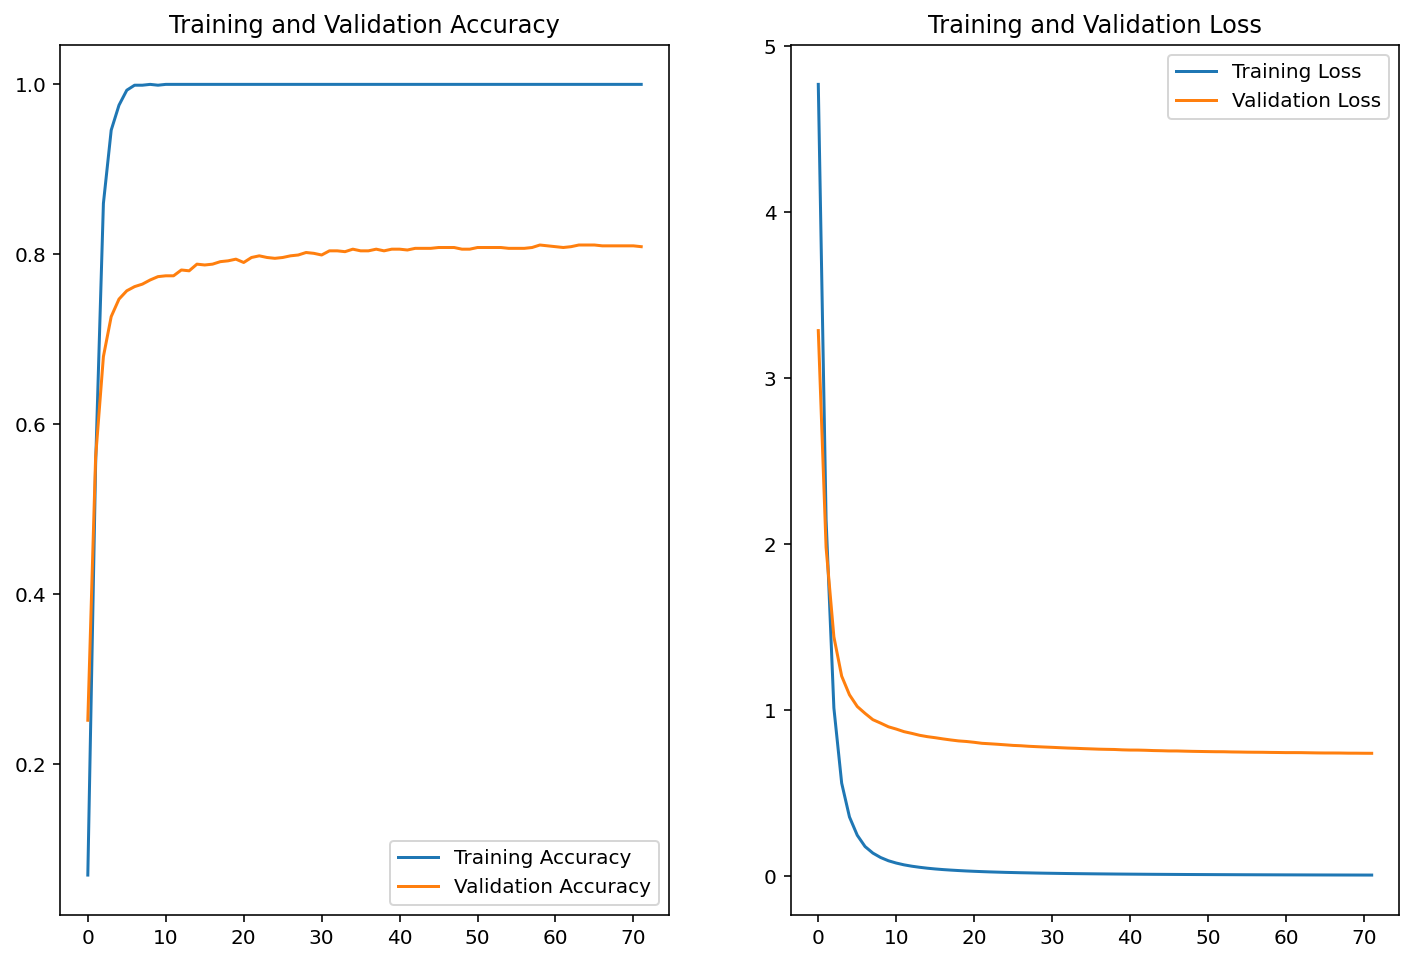

In [63]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the plot, training and validation accuracies quickly hit plateaus (more than 90% and 70% respectively) wtihin 10 Epochs of training. The model eventually stopped training at EPOCH 72 using the early stopping parameters specified.

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

### Testing on a batch of test set images

In [67]:
# Make predictions on a batch of testing set images

for image, label in testing_batches.take(1):
    ps = model.predict(image)
    images = image.numpy().squeeze()
    labels = label.numpy() + 1

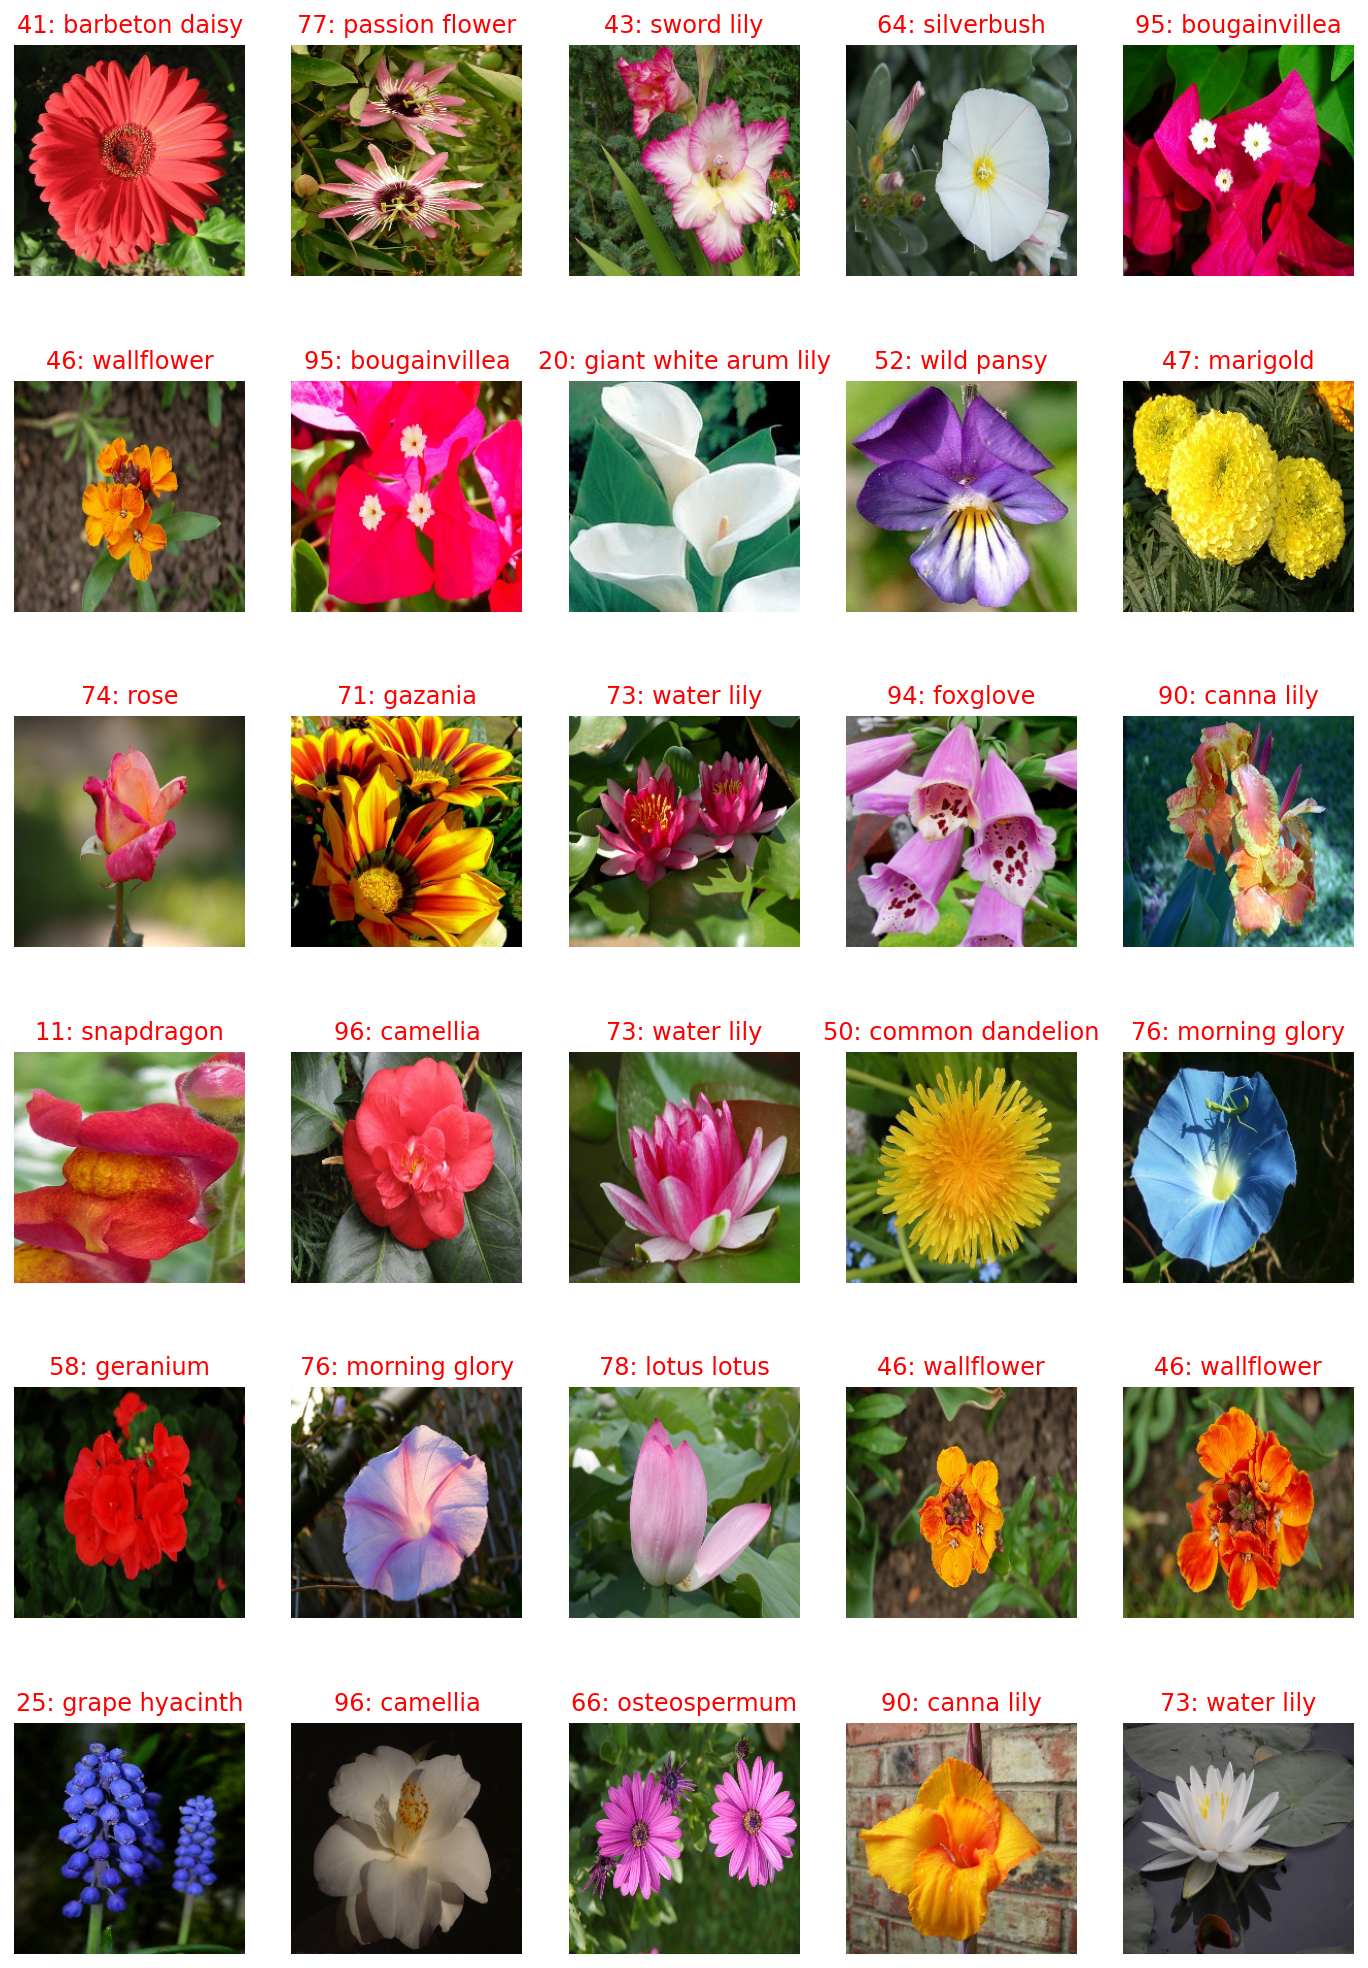

In [68]:
# Display predictions on a batch of testing set images

plt.figure(figsize=(12,18))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n])
    # To display titles of images that are correctly predicted in green, and red otherwise
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(str(labels[n]) + ": " + class_names[str(labels[n])], color = color )

    plt.axis('off')

### Evaluate model on entire test set

In [74]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

# Evaluate model on all testing batches

score = model.evaluate(testing_batches)


97/97 [==============================] - ETA: 2:09 - loss: 0.8513 - accuracy: 0.75 - ETA: 1:48 - loss: 0.7905 - accuracy: 0.78 - ETA: 1:45 - loss: 0.9022 - accuracy: 0.77 - ETA: 1:43 - loss: 0.8954 - accuracy: 0.77 - ETA: 1:42 - loss: 0.9416 - accuracy: 0.76 - ETA: 1:40 - loss: 0.9640 - accuracy: 0.76 - ETA: 1:39 - loss: 0.9856 - accuracy: 0.75 - ETA: 1:38 - loss: 0.9555 - accuracy: 0.75 - ETA: 1:37 - loss: 0.9386 - accuracy: 0.76 - ETA: 1:36 - loss: 0.9159 - accuracy: 0.77 - ETA: 1:34 - loss: 0.9371 - accuracy: 0.76 - ETA: 1:33 - loss: 0.9372 - accuracy: 0.76 - ETA: 1:31 - loss: 0.9383 - accuracy: 0.76 - ETA: 1:30 - loss: 0.9581 - accuracy: 0.76 - ETA: 1:29 - loss: 0.9564 - accuracy: 0.76 - ETA: 1:27 - loss: 0.9445 - accuracy: 0.76 - ETA: 1:26 - loss: 0.9257 - accuracy: 0.76 - ETA: 1:25 - loss: 0.9306 - accuracy: 0.76 - ETA: 1:25 - loss: 0.9385 - accuracy: 0.76 - ETA: 1:24 - loss: 0.9491 - accuracy: 0.75 - ETA: 1:24 - loss: 0.9440 - accuracy: 0.75 - ETA: 1:23 - loss: 0.9307 - accuracy

In [75]:
#Print the loss and accuracy values
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.8935085535049438
Test accuracy: 0.77394700050354


My model achieves an accuracy of 77.4% on the test images. There is scope to improve the model further but for now, we will work with the model

### Making Predictions from test dataset

In [76]:
# Predict labels from testing_batches
predictions = model.predict(testing_batches)

In [77]:
print('Type of predictions object', type(predictions))
print('Number of elements in predictions object:', len(predictions))
print('Shape of predictions object: ', predictions.shape)

Type of predictions object <class 'numpy.ndarray'>
Number of elements in predictions object: 6149
Shape of predictions object:  (6149, 102)


In [78]:
# Index of the max probability of first image
np.argmax(predictions[0])

40

 The columns are zero-based indices. But the dictionary keys start from 1. Therefore to get the label number corresponding to the dictionary, we need to +1 to the index

In [79]:
# Max predicted Probability value of first image
predictions[0][np.argmax(predictions[0])]

0.9974617

Predictions are in 6149 x 102 numpy array. THe 6149 rows represent each image, and the 102 columns represent the probabilties of each of the 102 possible flower classes. The predicted label for the image is given by the maxinum value in each row and can be retrieved with np.argmax.

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [80]:
# TODO: Save your trained model in working directory as a Keras model.

# Append timestamp to model  
import time
t = time.time()

saved_keras_model_filepath = './my_model_{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)

In [98]:
ls

 Volume in drive D is Data
 Volume Serial Number is 9629-5D23

 Directory of D:\Nanodegree ML\p2_image_classifier

20/09/2021  13:57    <DIR>          .
20/09/2021  13:57    <DIR>          ..
20/09/2021  09:11    <DIR>          .ipynb_checkpoints
20/09/2021  13:55    <DIR>          archive
11/09/2021  20:03    <DIR>          assets
04/09/2021  21:06             2,218 label_map.json
20/09/2021  13:52        15,646,788 my_model_1632117166.h5
20/09/2021  12:52             3,669 predict.py
20/09/2021  13:57         8,453,478 Project_Image_Classifier_Project.ipynb
04/09/2021  21:06             1,190 README.md
11/09/2021  15:21           215,336 rubric.pdf
11/09/2021  20:03    <DIR>          test_images
               6 File(s)     24,322,679 bytes
               6 Dir(s)  123,731,546,112 bytes free


## Load the Keras Model  -- To resume here if using trained network 

Load the Keras model you saved above.

In [90]:
# TODO: Load the Keras model from working directory

saved_keras_model_filepath = 'my_model_1632117166.h5'

reload_keras_saved_model = tf.keras.models.load_model(saved_keras_model_filepath, 
                                                      custom_objects={'KerasLayer': hub.KerasLayer})  # `custom_objects` tells keras how to load a `hub.KerasLayer`
reload_keras_saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 102)               102204    
Total params: 3,642,469
Trainable params: 102,204
Non-trainable params: 3,540,265
_________________________________________________________________


In [91]:
# Sanity check: to confirm my saved model make the same predictions as before

for image, label in testing_batches.take(1):
    prediction_1 = model.predict(image)
    prediction_2 = reload_keras_saved_model.predict(image)
    difference = np.abs(prediction_1 - prediction_2)  
    print(difference.max())   # Should be 0 if same predictions 

0.0


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [92]:
# TODO: Create the process_image function

def process_image(image):
  image = tf.convert_to_tensor(image)         # convert image numpy object to tensorflow object
  image = tf.cast(image, tf.float32) 
  image = tf.image.resize(image, (224, 224))   # reshape image to 224 x 224
  image = image/255                            # normalize pixels (0-255) to (0-1)
  image = image.numpy()                        # convert tf object to numpy array
  return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [93]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

In [94]:
# Confirm that the test image processing was successful
print(test_image.shape)
print(test_image.dtype)
print(processed_test_image.shape)
print(processed_test_image.dtype)

(591, 500, 3)
uint8
(224, 224, 3)
float32


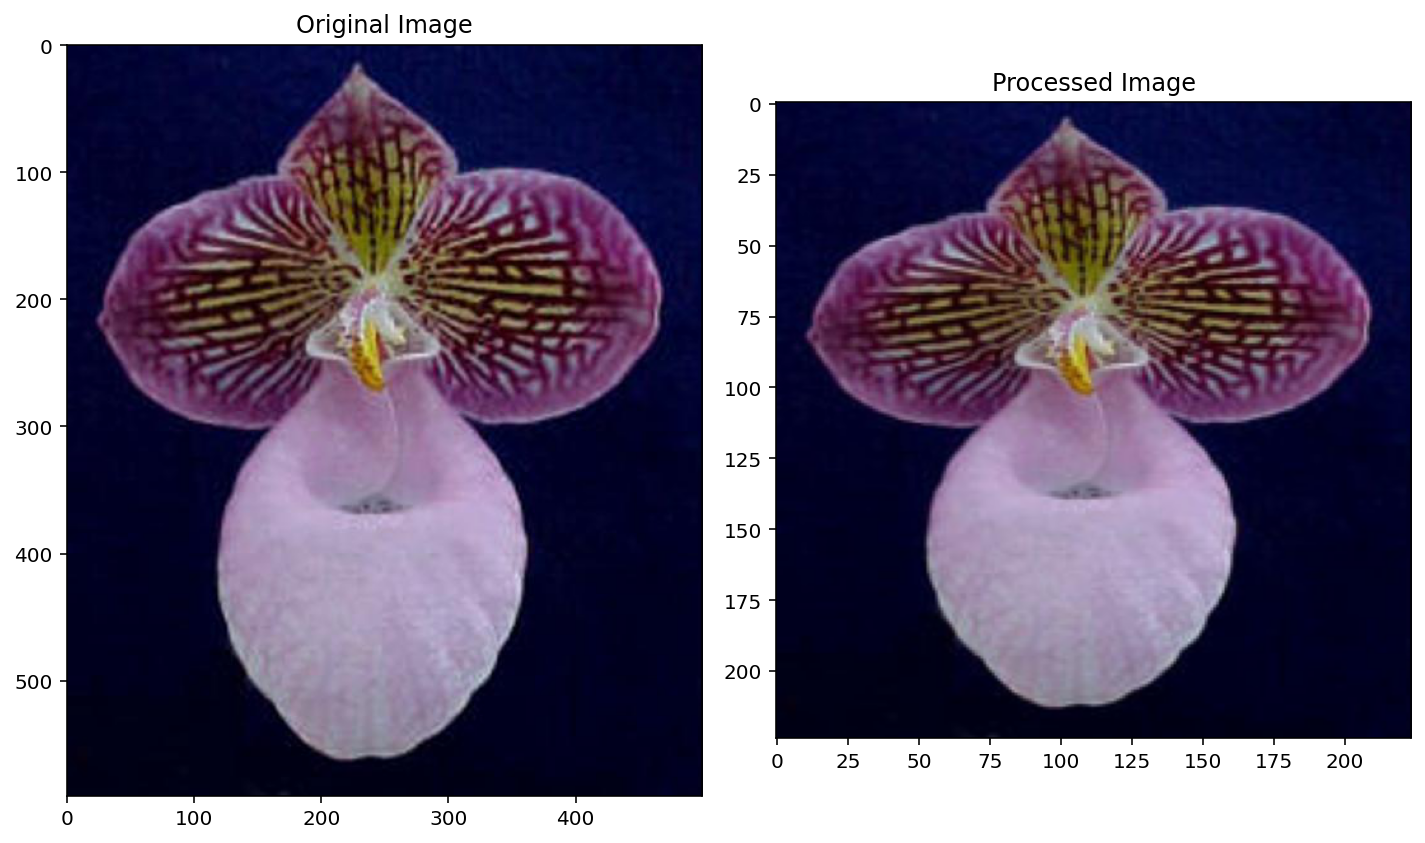

In [95]:
# Plot the raw and processed test image
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [96]:
# TODO: Create the predict function

def predict(image_path, model, top_k =5):
    
  # Load image using PIL Image method
  im = Image.open(image_path)
  im = np.asarray(im)  # convert image to numpy array

  # Process image using process_image function. Outputs image with shape (224, 224, 3 )
  im = process_image(im)    

  # Make prediction using trained model
  im = np.expand_dims(im, axis =0)   # convert image to (0,224,224,3)
  predictions = model.predict(im).squeeze()   # Prediction is in 1D numpy array of probabilities

  ## Retrieve Top N classes and their probabilities 
  indices = np.argsort(-predictions)[:top_k]        
  labels = indices +1
  probs = predictions[indices]
  # return flower names from class_names dictionary. Add 1 because the dictionary keys start from 1 wheras the indices start from 0
  classes = [class_names[str(i)] for i in labels]   
  return classes, probs

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

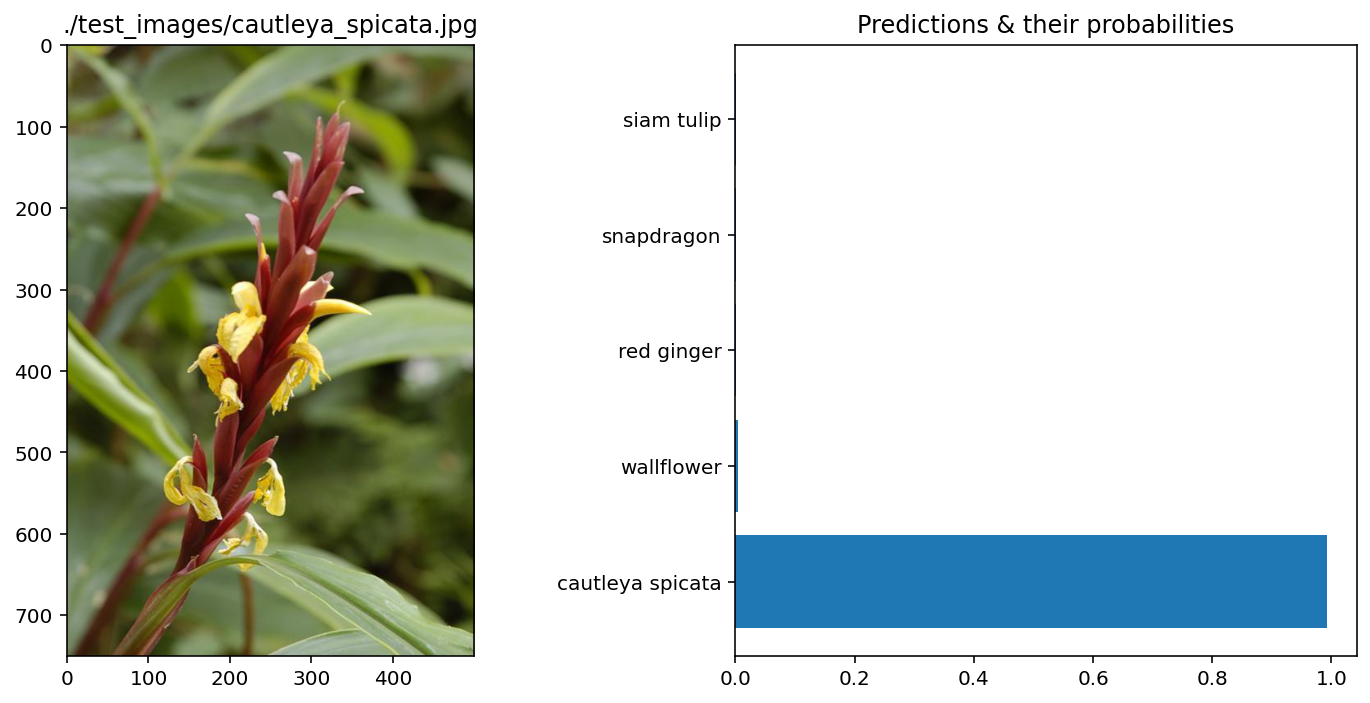

Top N predictions:
classes:  ['cautleya spicata', 'wallflower', 'red ginger', 'snapdragon', 'siam tulip']
Probabilities:  [0.993 0.004 0.001 0.001 0.   ]


In [36]:
# TODO: Plot the input image along with the top 5 classes

# Define model to use
model = reload_keras_saved_model

# Define path of image
image_path ='./test_images/cautleya_spicata.jpg'

# Make predictions
classes, probs = predict(image_path, model)

# Plot the image and predictions side by side
im = Image.open(image_path)  # Open image with PIL.image
test_image = np.asarray(im)  # Convert image to array

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)

ax1.imshow(test_image)
ax1.set_title(image_path)

ax2.barh(classes, probs)
ax2.set_title('Predictions & their probabilities')

#Display plot 
plt.tight_layout()
plt.show()

print("Top N predictions:")
print("classes: ",  classes)
print("Probabilities: ", np.round(list(probs), 3))

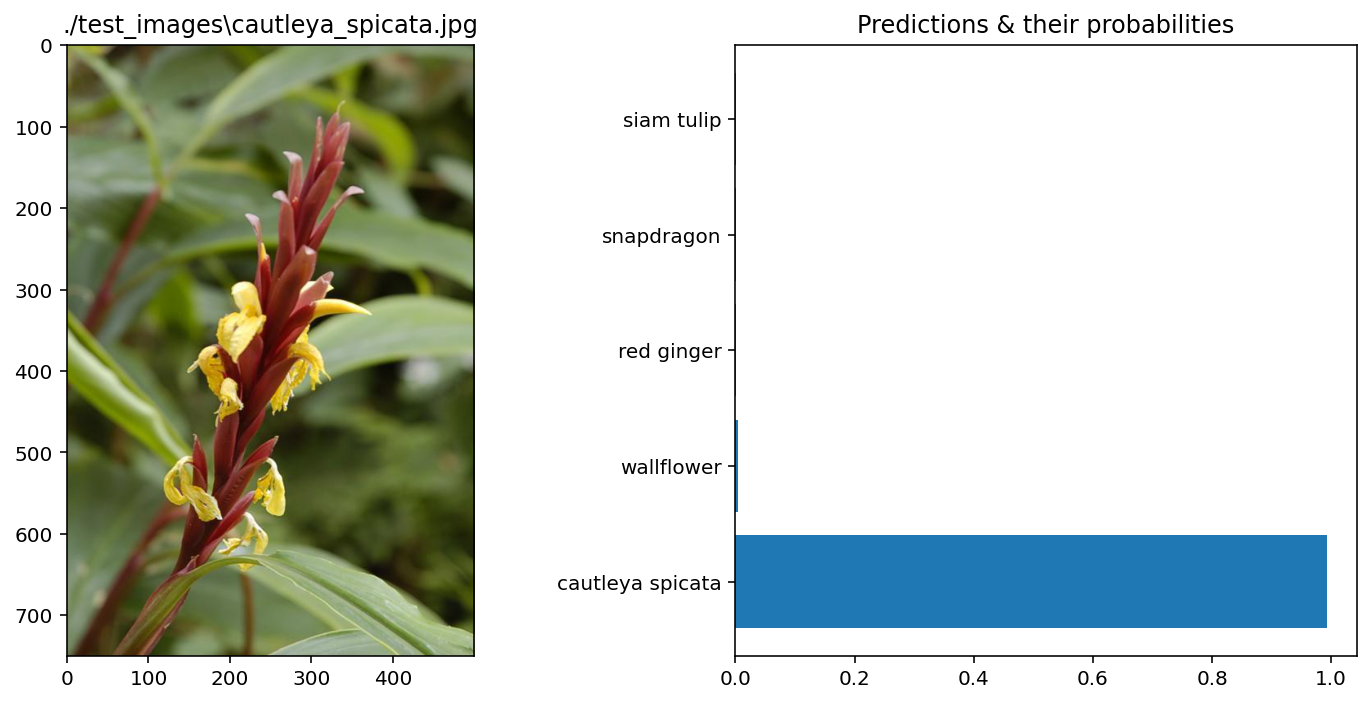

Top N predictions
Classes:  ['cautleya spicata', 'wallflower', 'red ginger', 'snapdragon', 'siam tulip']
Probabilities:  [0.993 0.004 0.001 0.001 0.   ]


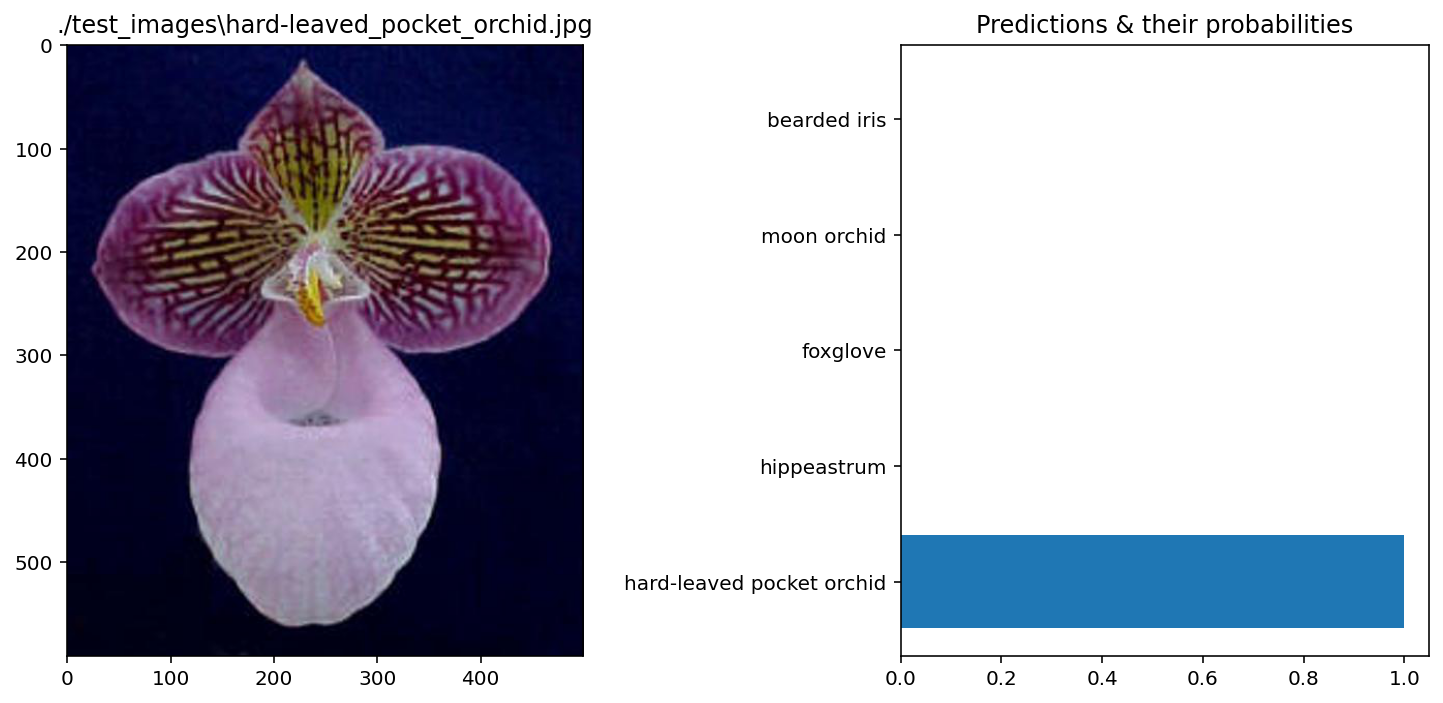

Top N predictions
Classes:  ['hard-leaved pocket orchid', 'hippeastrum', 'foxglove', 'moon orchid', 'bearded iris']
Probabilities:  [0.999 0.    0.    0.    0.   ]


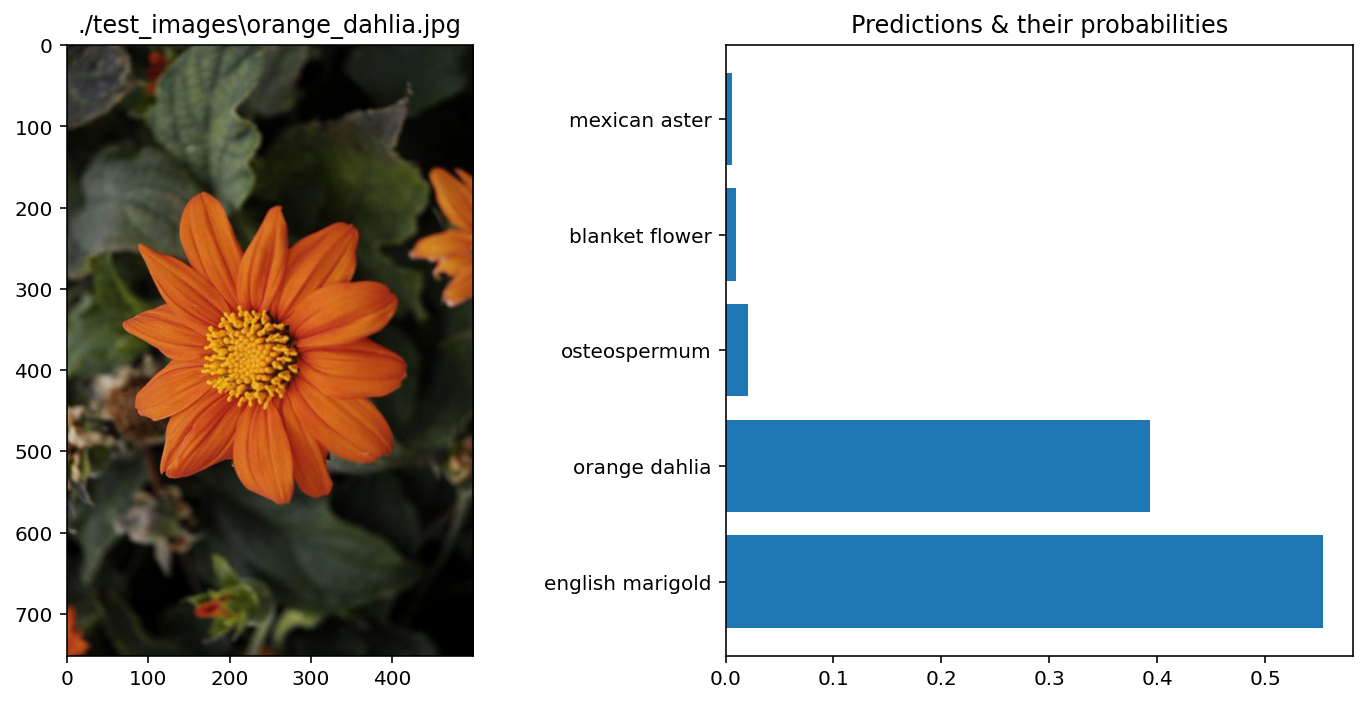

Top N predictions
Classes:  ['english marigold', 'orange dahlia', 'osteospermum', 'blanket flower', 'mexican aster']
Probabilities:  [0.554 0.393 0.021 0.009 0.006]


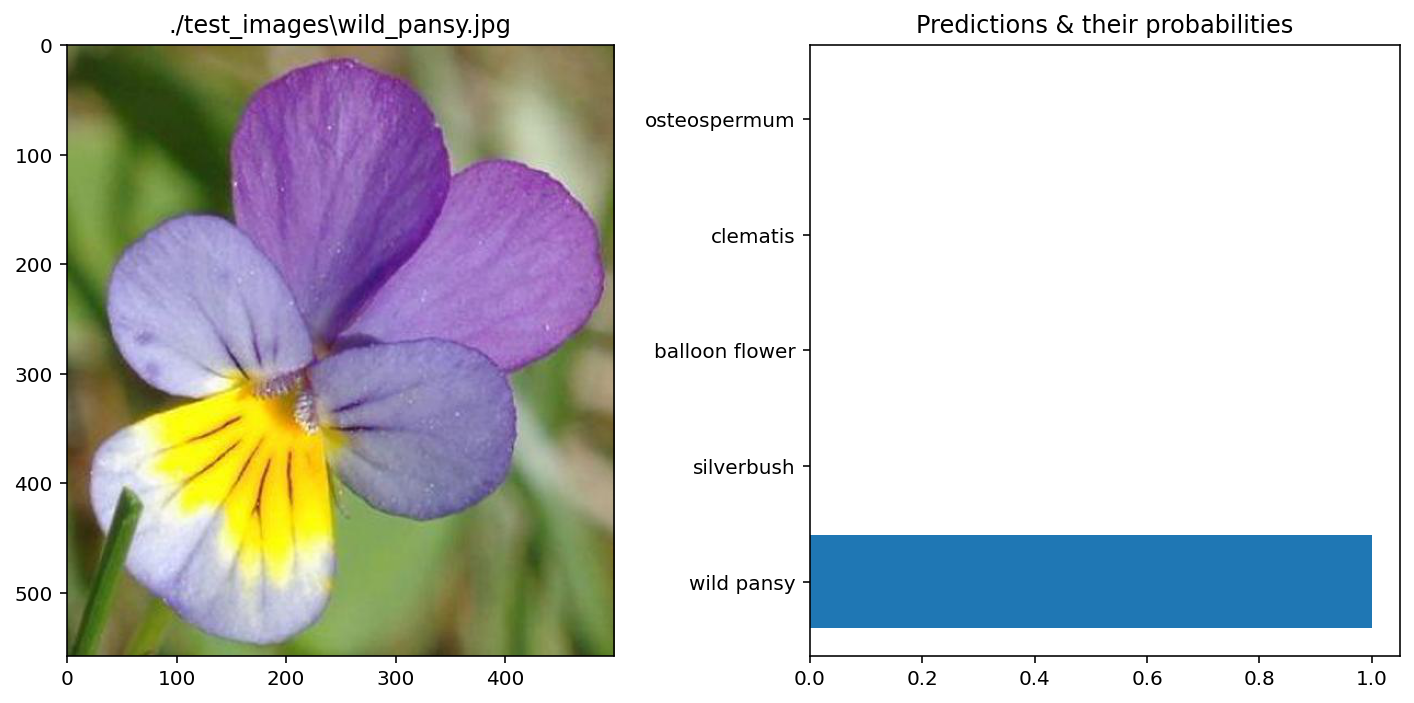

Top N predictions
Classes:  ['wild pansy', 'silverbush', 'balloon flower', 'clematis', 'osteospermum']
Probabilities:  [1. 0. 0. 0. 0.]


In [97]:
# Repeat but looping through each image in folder

import glob

files = glob.glob('./test_images/*')

for image_path in files:
  
  # Make predictions
  classes, probs = predict(image_path, model, top_k=5)

  # Plot the image and predictions side by side
  im = Image.open(image_path)  # Open image with PIL.image
  test_image = np.asarray(im)  # Convert image to array

  fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)

  ax1.imshow(test_image)
  ax1.set_title(image_path)

  ax2.barh(classes, probs)
  ax2.set_title('Predictions & their probabilities')

  #Display plot 
  plt.tight_layout()
  plt.show()

  print("Top N predictions")
  print("Classes: ", classes)
  print("Probabilities: ", np.round(list(probs), 3))

# Conclusion
From the results of the test images evaluation, the model predicted 3 out of 4 images with probabilities of almost 1.

However, the prediction was less convincing for the orange dahlia test image. The model predicted marigold as #1 with a probability of ~0.55 followed closely by orange dahlia with a probability of ~0.4.

The results (3/4 images accurately predicted) are not unexpected because when we built and test the model earlier, we found that model had an accuracy of ~77%.

In [99]:
 !jupyter nbconvert --to html Project_Image_Classifier_Project.ipynb

[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html
[NbConvertApp] Writing 8777523 bytes to Project_Image_Classifier_Project.html
